In [33]:
import matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, pandas as pd, os, glob
import ast
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import rankdata
from scipy.stats import ttest_ind

In [34]:
plt.rcParams.update({
    "axes.titlesize": 18,   # subplot titles
    "axes.labelsize": 16,   # x/y labels
    "xtick.labelsize": 14,  # x ticks
    "ytick.labelsize": 14,  # y ticks
})

# 1. preprocess

In [35]:
# subj_info
raw_subjs = [202509, 202511, 202512, 202518, 'amisha', 'erfan', 'tori']
patients = ['09', '11', '12', '18']
pilots = ['A', 'E', 'T']
subjs = patients + pilots
subj_map = {202509.0: '09', 202511.0: '11', 202512.0: '12', 202518.0: '18',
            'amisha': 'A', 'erfan': 'E', 'tori': 'T'}

load and format df

In [36]:
df_subjs = pd.DataFrame()

# init new cols
for col in ['dir_flip', 'sess_flip',
            'chosen_pos_aligned', 'div_pos_aligned', 'stim_pos_aligned',
            'true_class', 'pred_class', 'err_type',
            'invalid', 'missed', 'purely_incorrect',
            'signed_err', 'unsigned_err',
            'dist_moved', 'normed_RT',
            'difficulty', 'stim_aligned_to_div',
            'resp_aligned_to_div', 'stim_aligned_to_cntxt', 'resp_aligned_to_cntxt']:
    df_subjs[col] = np.nan

for raw_subj in raw_subjs:

    df_subj = pd.read_csv(glob.glob(f'../../results/psychopy/*{raw_subj}*')[0])[:240]
    df_subj['subj'] = df_subj['subj'].replace(subj_map)

    # # trial sort
    # df_subj = df_subj.sort_values(by='trial_key').reset_index(drop=True)
    # assert df_subj['trial_key'].is_monotonic_increasing, 'trial_key is not sorted correctly'

    # convert str to list, and store chosen position
    for col in ['positions']:
        if type(df_subj[col][0]) == str:
            df_subj.loc[:, col] = df_subj[col].apply(ast.literal_eval)
            
    df_subj['chosen_pos'] = df_subj['positions'].apply(lambda x: x[-1])
    
## must sequentially align for flips & sessions because of the double flip situations

# 1. aligning for direction flips
    df_subj['dir_flip'] = (df_subj['shape_order'] == 'flat_curv').astype(int)
    assert df_subj['dir_flip'].sum() == len(df_subj)/2
   
   # align positions to curv=left, flat=right
    for col_prefix in ['chosen_pos', 'div_pos']: # dont need to unflip stim_pos because it never gets flipped; only target_pos does
        df_subj[col_prefix + '_aligned'] = np.where( df_subj['dir_flip'],
                                                     -df_subj[col_prefix], df_subj[col_prefix] )

# 2. aligning for session type (stim-val association)
    if df_subj['sess_type'][0] in ['A', 'C']: # adam, tori       
        df_subj['condition'] = df_subj['condition'].map({'baseline':'baseline', 'curv_comp':'pen_comp', 'flat_comp':'rew_comp'})
        df_subj['sess_flip'] = 0
        df_subj['stim_pos_aligned'] = df_subj['stim_pos']

    elif df_subj['sess_type'][0] in ['B', 'D']: # amisha, erfan     
        df_subj['condition'] = df_subj['condition'].map({'baseline':'baseline', 'curv_comp':'rew_comp', 'flat_comp':'pen_comp'})
        df_subj['sess_flip'] = 1
        df_subj['stim_pos_aligned'] = -df_subj['stim_pos']

        # align positions to penalty=left, reward=right
        for col in ['chosen_pos_aligned', 'div_pos_aligned']:
            df_subj[col] = -df_subj[col]

    df_subjs = pd.concat([df_subjs, df_subj], ignore_index=True)

# category stuff
df_subjs['true_class'] = np.where( df_subjs['valence'] == 'rew', 1, 0 ) 
df_subjs['pred_class'] = (df_subjs['div_pos_aligned'] < df_subjs['chosen_pos_aligned']).astype(int)
df_subjs['err_type'] = df_subjs['pred_class'] - df_subjs['true_class']

# outcome stuff
df_subjs['outcome'] = df_subjs['outcome'].replace({2: 3, -2: -3}) # older versions
# for PILOTS, convert 0 to -1 or -3 depending on whether true_class is 1 or 0
df_subjs['outcome'] = np.where( (df_subjs['true_class'] == 1) & (df_subjs['outcome'] == 0), -1,
                             np.where( (df_subjs['true_class'] == 0) & (df_subjs['outcome'] == 0), -3,
                                      df_subjs['outcome'] ) )

# invalid and missed trials
df_subjs['invalid'] = df_subjs['trials.slider_resp.rt'].isna()
df_subjs['missed'] = df_subjs['trials.submit_resp.keys'].isna()
df_subjs['purely_incorrect'] = (df_subjs['correct']==0) & ~df_subjs['trials.slider_resp.rt'].isna() & ~df_subjs['trials.submit_resp.keys'].isna()

# continuous resp
df_subjs['signed_err'] = df_subjs['chosen_pos_aligned'] - df_subjs['stim_pos_aligned']
df_subjs['unsigned_err'] = (df_subjs['chosen_pos_aligned'] - df_subjs['stim_pos_aligned']).abs()

# RT
df_subjs['dist_moved'] = (df_subjs['chosen_pos'] - df_subjs['marker_init']).abs()
df_subjs['normed_RT'] = df_subjs['trials.submit_resp.rt']/ (10 * (df_subjs['dist_moved'] + .01) )

# boundary stuff
df_subjs['difficulty'] = (df_subjs['stim_pos_aligned'] - df_subjs['div_pos_aligned']).abs() < 0.1
df_subjs['stim_aligned_to_div'] = (df_subjs['stim_pos_aligned'] - df_subjs['div_pos_aligned']).round(3)
df_subjs['resp_aligned_to_div'] = (df_subjs['chosen_pos_aligned'] - df_subjs['div_pos_aligned']).round(3)
# if loss,  if stim is on penalty side of div, pos if on reward side
df_subjs['stim_aligned_to_cntxt'] = np.where( df_subjs['true_class'] == 1, df_subjs['stim_aligned_to_div'], - df_subjs['stim_aligned_to_div'] )
df_subjs['resp_aligned_to_cntxt'] = np.where( df_subjs['true_class'] == 1, df_subjs['resp_aligned_to_div'], - df_subjs['resp_aligned_to_div'] )

# rank within a block for each subj/cond
grp = ['subj', 'condition', 'blockN']
# build both ranks, assign once, then copy to defragment
df_subjs = df_subjs.assign(
    stim_ranks = df_subjs.groupby(grp)['stim_pos_aligned'].transform('rank'),
    resp_ranks = df_subjs.groupby(grp)['chosen_pos_aligned'].transform('rank'),
).copy()
max_rank = df_subjs['stim_ranks'].max()

df_subjs = df_subjs.copy()

# asserts
df_subjs.to_csv('../../results/psychopy/all_subjs_clean.csv', index=False)

print(df_subjs['outcome'].value_counts(), '\n')
print(df_subjs['correct'].value_counts(), '\n')
print(df_subjs.shape, '\n')
print(len(df_subjs))
assert len(df_subjs) == 240 * len(raw_subjs), "Total trials do not match expected number"

disp_cols = ['sess_type', 'sess_flip', 'shape_order', 'dir_flip', 'target_pos', 'shape', 'valence', 'true_class',
             'div_pos', 'div_pos_aligned', 'stim_pos', 'stim_pos_aligned', 'chosen_pos', 'chosen_pos_aligned', 'pred_class', 'err_type',
             'signed_err', 'unsigned_err']

df_subjs[(df_subjs['sess_type'] == 'B') &
         (df_subjs['condition'] == 'baseline') &
         (df_subjs['err_type'] != 0) &
         (df_subjs['sess_flip'] != df_subjs['dir_flip'])
        ][disp_cols][:20]


outcome
 1.0    683
 3.0    664
-1.0    176
-3.0    157
Name: count, dtype: int64 

correct
1.0    1347
0.0     333
Name: count, dtype: int64 

(1680, 157) 

1680


,sess_type,sess_flip,shape_order,dir_flip,target_pos,shape,valence,true_class,div_pos,div_pos_aligned,stim_pos,stim_pos_aligned,chosen_pos,chosen_pos_aligned,pred_class,err_type,signed_err,unsigned_err
241,B,1.0,curv_flat,0.0,-0.18,curv,rew,1,0.0,-0.0,-0.18,0.18,0.016,-0.016,0,-1,-0.196,0.196
243,B,1.0,curv_flat,0.0,-0.30,curv,rew,1,0.0,-0.0,-0.30,0.30,0.040,-0.040,0,-1,-0.340,0.340
262,B,1.0,curv_flat,0.0,-0.02,curv,rew,1,0.0,-0.0,-0.02,0.02,0.068,-0.068,0,-1,-0.088,0.088
264,B,1.0,curv_flat,0.0,-0.10,curv,rew,1,0.0,-0.0,-0.10,0.10,0.024,-0.024,0,-1,-0.124,0.124
275,B,1.0,curv_flat,0.0,0.02,flat,pen,0,0.0,-0.0,0.02,-0.02,-0.220,0.220,1,1,0.240,0.240
400,B,1.0,curv_flat,0.0,-0.30,curv,rew,1,0.0,-0.0,-0.30,0.30,0.016,-0.016,0,-1,-0.316,0.316
408,B,1.0,curv_flat,0.0,-0.02,curv,rew,1,0.0,-0.0,-0.02,0.02,0.048,-0.048,0,-1,-0.068,0.068
411,B,1.0,curv_flat,0.0,0.30,flat,pen,0,0.0,-0.0,0.30,-0.30,-0.036,0.036,1,1,0.336,0.336
415,B,1.0,curv_flat,0.0,-0.14,curv,rew,1,0.0,-0.0,-0.14,0.14,0.012,-0.012,0,-1,-0.152,0.152
423,B,1.0,curv_flat,0.0,-0.26,curv,rew,1,0.0,-0.0,-0.26,0.26,0.040,-0.040,0,-1,-0.300,0.300


In [37]:
# use groupby.head(1) to keep the first trial for each subject
df_first_per_subj = df_subjs.groupby('subj').head(1)[['subj', 'sess_type']].reset_index(drop=True)
df_first_per_subj

,subj,sess_type
0,09,A
1,11,B
2,12,C
3,18,D
4,A,B
5,E,B
6,T,C


# 2. read df

In [38]:
df_clean = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
df_clean

,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,true_class,pred_class,err_type,invalid,missed,...,Mcross.started,Mcross.stopped,Lcross.started,Rcross.started,Lcross.stopped,Rcross.stopped,Unnamed: 122,Unnamed: 115,stim_ranks,resp_ranks
0,0.0,0.0,0.064,0.0,-0.18,0,1,1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5,34.5
1,1.0,0.0,-0.100,-0.0,-0.26,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,6.0
2,1.0,0.0,0.136,-0.0,0.34,1,1,0,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.5,40.0
3,0.0,0.0,-0.136,0.0,-0.10,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5,4.0
4,0.0,0.0,0.056,0.0,-0.22,0,1,1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,1.0,0.0,0.285,0.2,0.22,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.5,34.0
1676,0.0,0.0,0.112,0.2,-0.10,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.5,8.0
1677,0.0,0.0,0.322,0.2,0.30,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5,39.0
1678,0.0,0.0,0.303,0.2,0.38,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.5,37.5


In [39]:
# a function to choose whether plotting for subj or pop
def get_df(df, subj_or_pop):
    return subj_or_pop, df.copy() if subj_or_pop == 'pop' else df[df['subj'] == subj_or_pop].copy()

# test
subj_or_pop, df_analysis = get_df(df_clean, '18')
print(f'\nplotting for subj-{subj_or_pop}\nlen(df) = {len(df_analysis)}')
df_analysis


plotting for subj-18
len(df) = 240


,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,true_class,pred_class,err_type,invalid,missed,...,Mcross.started,Mcross.stopped,Lcross.started,Rcross.started,Lcross.stopped,Rcross.stopped,Unnamed: 122,Unnamed: 115,stim_ranks,resp_ranks
720,1.0,1.0,0.108,0.0,0.38,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.5,39.0
721,0.0,1.0,-0.032,-0.0,0.14,1,0,-1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.5,21.0
722,0.0,1.0,-0.200,-0.0,-0.06,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.5,2.5
723,0.0,1.0,-0.116,-0.0,-0.18,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5,10.0
724,1.0,1.0,-0.116,0.0,-0.02,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.5,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,0.0,1.0,-0.236,-0.2,-0.38,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,10.0
956,0.0,1.0,-0.240,-0.2,-0.26,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.5,8.5
957,1.0,1.0,-0.220,-0.2,-0.22,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.5,14.0
958,0.0,1.0,-0.256,-0.2,-0.18,1,0,-1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,6.0


# 3. checks

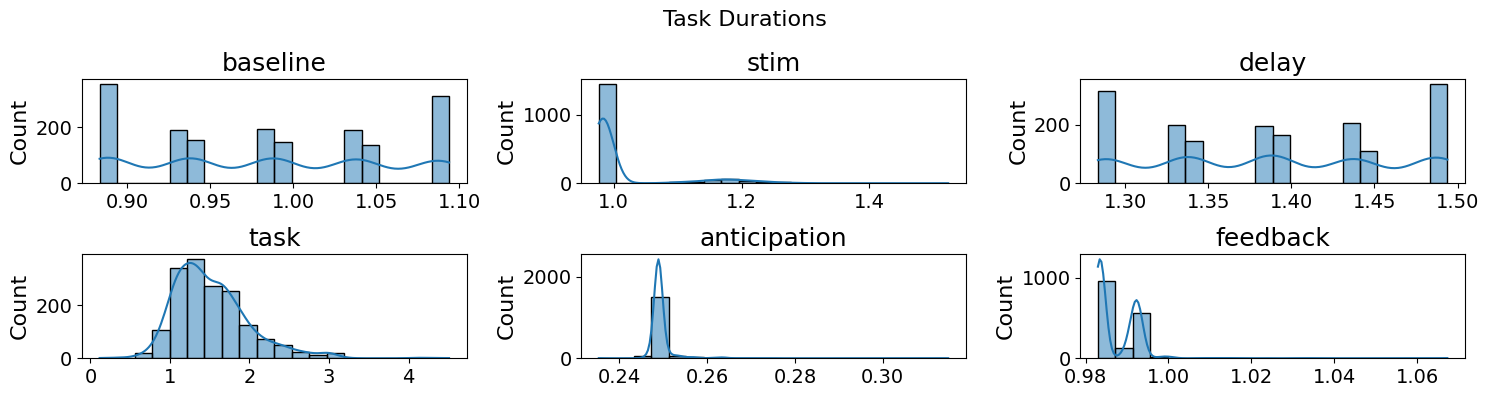

In [40]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# create column for each phases's duration
expt_phases = ['baseline', 'stim', 'delay', 'task', 'anticipation', 'feedback']
for phase in expt_phases:
    df_analysis[f'{phase}_dur'] = df_analysis[f'{phase}.stopped'] - df_analysis[f'{phase}.started']

# sid, check if these are needed replacements
df_analysis['stim_dur'] = df_analysis['stim.stopped'] - df_analysis['target_stim.started']
df_analysis['feedback_dur'] = df_analysis['feedback.stopped'] - df_analysis['no_resp_text.started']

fig, axs = plt.subplots(2, 3, figsize=(15, 4))
axs, ax = axs.flatten(), 0

for expt_phase in expt_phases:

    sns.histplot(df_analysis[f'{expt_phase}_dur'], bins=20, kde=True, ax=axs[ax])
    axs[ax].set(title=expt_phase, xlabel='', ylabel='Count')
    ax += 1

plt.suptitle(f'Task Durations', fontsize=16)
plt.tight_layout()
plt.show()

# print which trials with feedback duration < .99
# short_feedback = df_analysis.loc[df_analysis['feedback_dur'] < 0.998]
# print(f'{len(short_feedback)} trials: {short_feedback.index.tolist()}')

In [41]:
subj_or_pop, df_analysis = get_df(df_subjs, '09')
print(len(df_analysis))

num_missed = df_analysis['missed'].sum()
num_invalid = df_analysis['invalid'].sum()
num_purely_incorrect = df_analysis['purely_incorrect'].sum()
print(f'patient: {subj_or_pop}')
print(f'\
missed: {num_missed} ({num_missed / 240 * 100:.2f}%),\
 invalid: {num_invalid} ({num_invalid / 240 * 100:.2f}%),\
 incorrect: {num_purely_incorrect} ({num_purely_incorrect / 240 * 100:.2f}%)')

# proportion correct
prop_correct = df_analysis['correct'].mean()
print(f'Proportion correct: {prop_correct:.2f}')

# pearson and spearman correlations between stim_pos_aligned and chosen_pos_aligned
pearson_corr = df_analysis['stim_pos_aligned'].corr(df_analysis['chosen_pos_aligned'], method='pearson')
spearman_corr = df_analysis['stim_pos_aligned'].corr(df_analysis['chosen_pos_aligned'], method='spearman')
print(f'Pearson correlation: {pearson_corr:.2f}')
print(f'Spearman correlation: {spearman_corr:.2f}')

# ensure this is the same
pearson_corr = df_analysis['target_pos'].corr(df_analysis['chosen_pos'], method='pearson')
spearman_corr = df_analysis['target_pos'].corr(df_analysis['chosen_pos'], method='spearman')
print(f'Pearson correlation (target_pos vs chosen_pos): {pearson_corr:.2f}')
print(f'Spearman correlation (target_pos vs chosen_pos): {spearman_corr:.2f}')

print(df_analysis['outcome'].value_counts(), '\n')


240
patient: 09
missed: 2 (0.83%), invalid: 6 (2.50%), incorrect: 43 (17.92%)
Proportion correct: 0.79
Pearson correlation: 0.73
Spearman correlation: 0.72
Pearson correlation (target_pos vs chosen_pos): 0.73
Spearman correlation (target_pos vs chosen_pos): 0.73
outcome
 3.0    100
 1.0     89
-3.0     31
-1.0     20
Name: count, dtype: int64 



## strategies

In [42]:
conds = ['pen_comp', 'baseline', 'rew_comp']
cond2name = {'pen_comp': 'gain_exp', 'baseline': 'baseline', 'rew_comp': 'loss_exp'}
pt_colors = ['g','r','orange','b']

## NOTE: p_vals sigfig only when i exclude invalid/missed trials

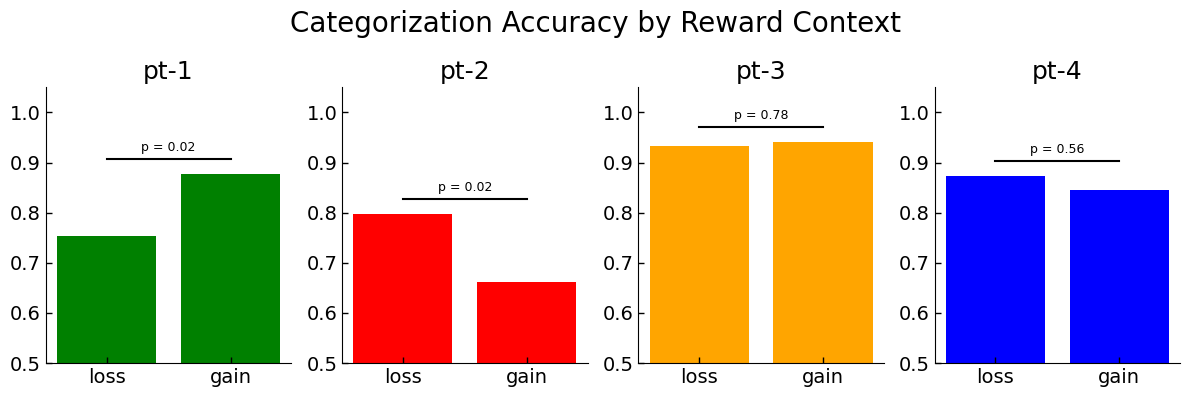

In [43]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')
# drop missed or invalid trials
df_analysis = df_analysis[~df_analysis['missed'] & ~df_analysis['invalid']]

n_rows, n_cols = 1, 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 4*n_rows))
axs, ax = axs.flatten(), 0
colors = ['g','r','orange','b']

for subj_idx in range(len(patients)):

    subj_df = df_analysis[df_analysis['subj'] == patients[subj_idx]].copy()
    acc_by_contxt = subj_df.groupby('true_class')['correct'].mean()

    axs[ax].bar(acc_by_contxt.index, acc_by_contxt.values, color=[pt_colors[subj_idx]])
    axs[ax].set(title=f'pt-{subj_idx+1}',
                ylim=(.5, 1.05), xticks=[0, 1], xticklabels=['loss', 'gain'])

    # stats
    loss_acc = subj_df[subj_df['true_class'] == 0]['correct']
    gain_acc = subj_df[subj_df['true_class'] == 1]['correct']
    # simple independent-samples t-test on trial accuracies
    tval, pval = ttest_ind(loss_acc, gain_acc, equal_var=False)

    # 💬 Add p-value line + text on figure
    y_max = max(acc_by_contxt.values)
    y_line = y_max + 0.03
    axs[ax].plot([0, 1], [y_line, y_line], color='k', lw=1.5)
    axs[ax].text(0.5, y_line + 0.01, f"p = {pval:.2f}", ha='center', va='bottom', fontsize=9)

    ax += 1

for ax in axs:
    ax.tick_params(direction='in', length=4, width=1)
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.suptitle('Categorization Accuracy by Reward Context', fontsize=20)
plt.tight_layout()
plt.show()
# save as eps
# fig.savefig('../../results/figs/sfn/fig3a_accuracy.eps', format='eps', dpi=300)
plt.rcParams['svg.fonttype'] = 'none'  # keeps text editable
fig.savefig('../../results/figs/sfn/fig3a_accuracy.svg', format='svg', dpi=300)

plotting vars

In [44]:
cond2name = {'pen_comp': 'gain_exp', 'baseline': 'baseline', 'rew_comp': 'loss_exp'}

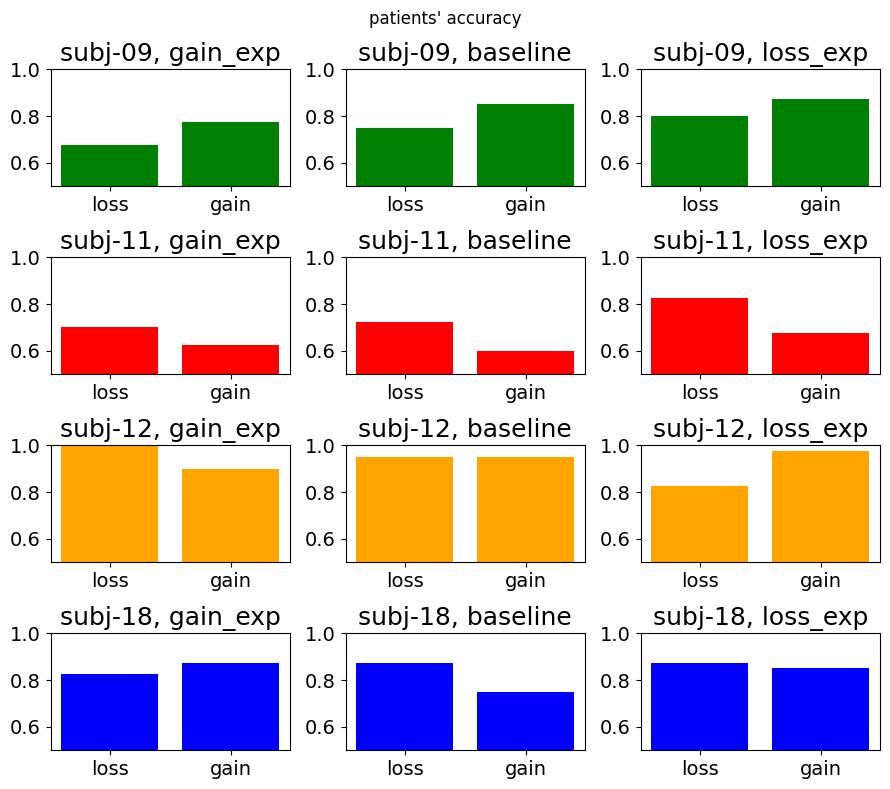

In [45]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

n_rows, n_cols = 4, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2*n_rows))
axs, ax = axs.flatten(), 0

pilotOrpatient = 1
subjs2plot = [pilots, patients][pilotOrpatient]
subj_title = ['pilots', 'patients'][pilotOrpatient]

for subj_idx in range(len(patients)):

    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == subjs2plot[subj_idx]) & (df_analysis['condition'] == cond)].copy()
        acc_by_contxt = subj_cond_df.groupby('true_class')['correct'].mean()

        axs[ax].bar(acc_by_contxt.index, acc_by_contxt.values, color=[pt_colors[subj_idx]])
        axs[ax].set(title=f'subj-{subjs2plot[subj_idx]}, {cond2name[cond]}', ylim=(.5, 1), xticks=[0, 1], xticklabels=['loss', 'gain'])
        ax += 1

# subplot adjust
plt.suptitle(f'{subj_title}\' accuracy')
plt.tight_layout()
plt.show()


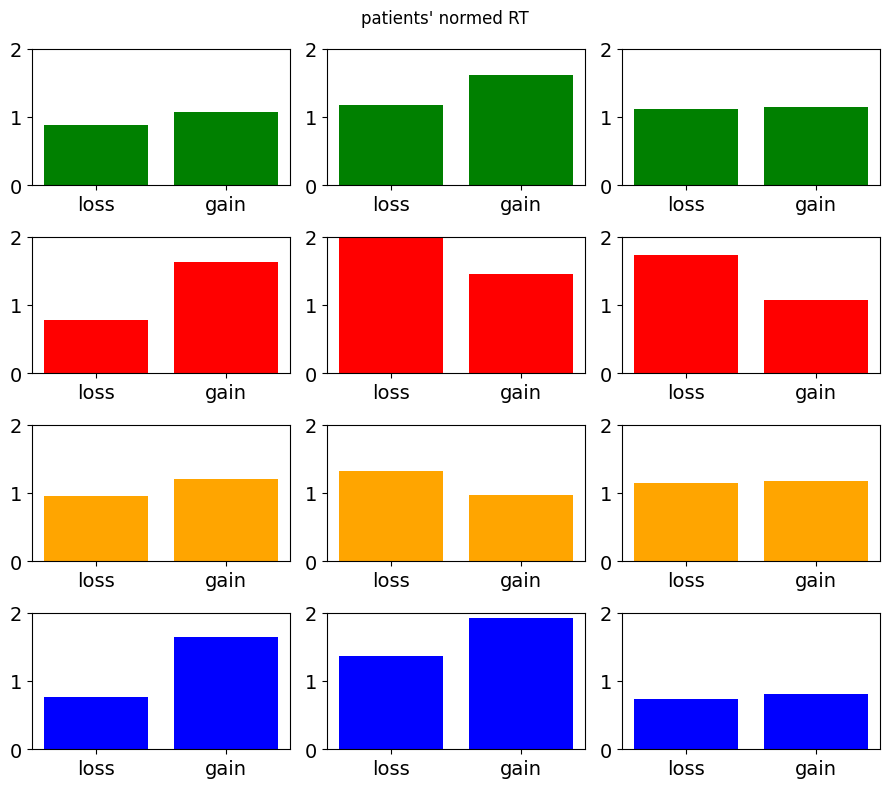

In [46]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

n_rows, n_cols = 4, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2*n_rows))
axs, ax = axs.flatten(), 0

pilotOrpatient = 1
subjs2plot = [pilots, patients][pilotOrpatient]
subj_title = ['pilots', 'patients'][pilotOrpatient]

for subj_idx in range(len(subjs2plot)):

    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == subjs2plot[subj_idx]) & (df_analysis['condition'] == cond)].copy()
        
        RT_by_cntxt = subj_cond_df.groupby('true_class')['normed_RT'].mean()
        axs[ax].bar(RT_by_cntxt.index, RT_by_cntxt.values, color=[colors[subj_idx]])
        
        axs[ax].set(ylim=(0, 2), xticks=[0, 1], xticklabels=['loss', 'gain'])
        ax += 1

# subplot adjust
plt.suptitle(f'{subj_title}\' normed RT')
plt.tight_layout()
plt.show()

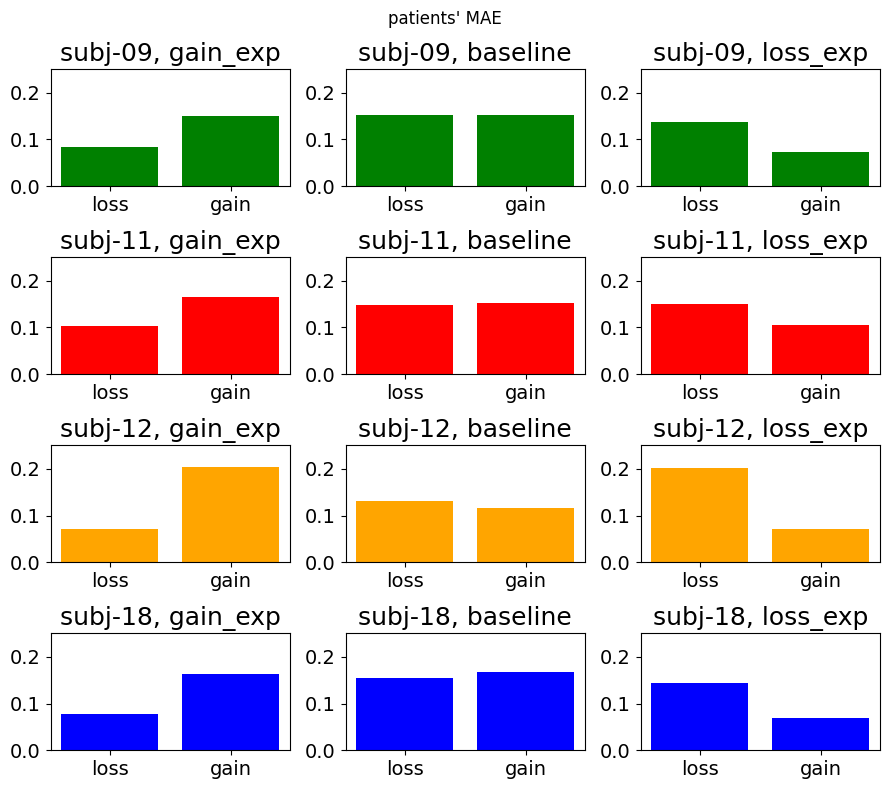

In [47]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

n_rows, n_cols = 4, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2*n_rows))
axs, ax = axs.flatten(), 0

pilotOrpatient = 1
subjs2plot = [pilots, patients][pilotOrpatient]
subj_title = ['pilots', 'patients'][pilotOrpatient]

for subj_idx in range(len(subjs2plot)):

    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == subjs2plot[subj_idx]) & (df_analysis['condition'] == cond)].copy()
        
        subj_cond_df['abs_err'] = np.abs(subj_cond_df['stim_pos_aligned'] - subj_cond_df['chosen_pos_aligned'])
        err_by_stim = subj_cond_df.groupby('true_class')['abs_err'].mean()
        axs[ax].bar(err_by_stim.index, err_by_stim.values, color=[pt_colors[subj_idx]])

        axs[ax].set(title=f'subj-{subjs2plot[subj_idx]}, {cond2name[cond]}', 
                    ylim=(0, .25), xticks=[0, 1], xticklabels=['loss', 'gain'])

        ax += 1

plt.suptitle(f'{subj_title}\' MAE')
plt.tight_layout()
plt.show()

## post-error correction

## choice distribution

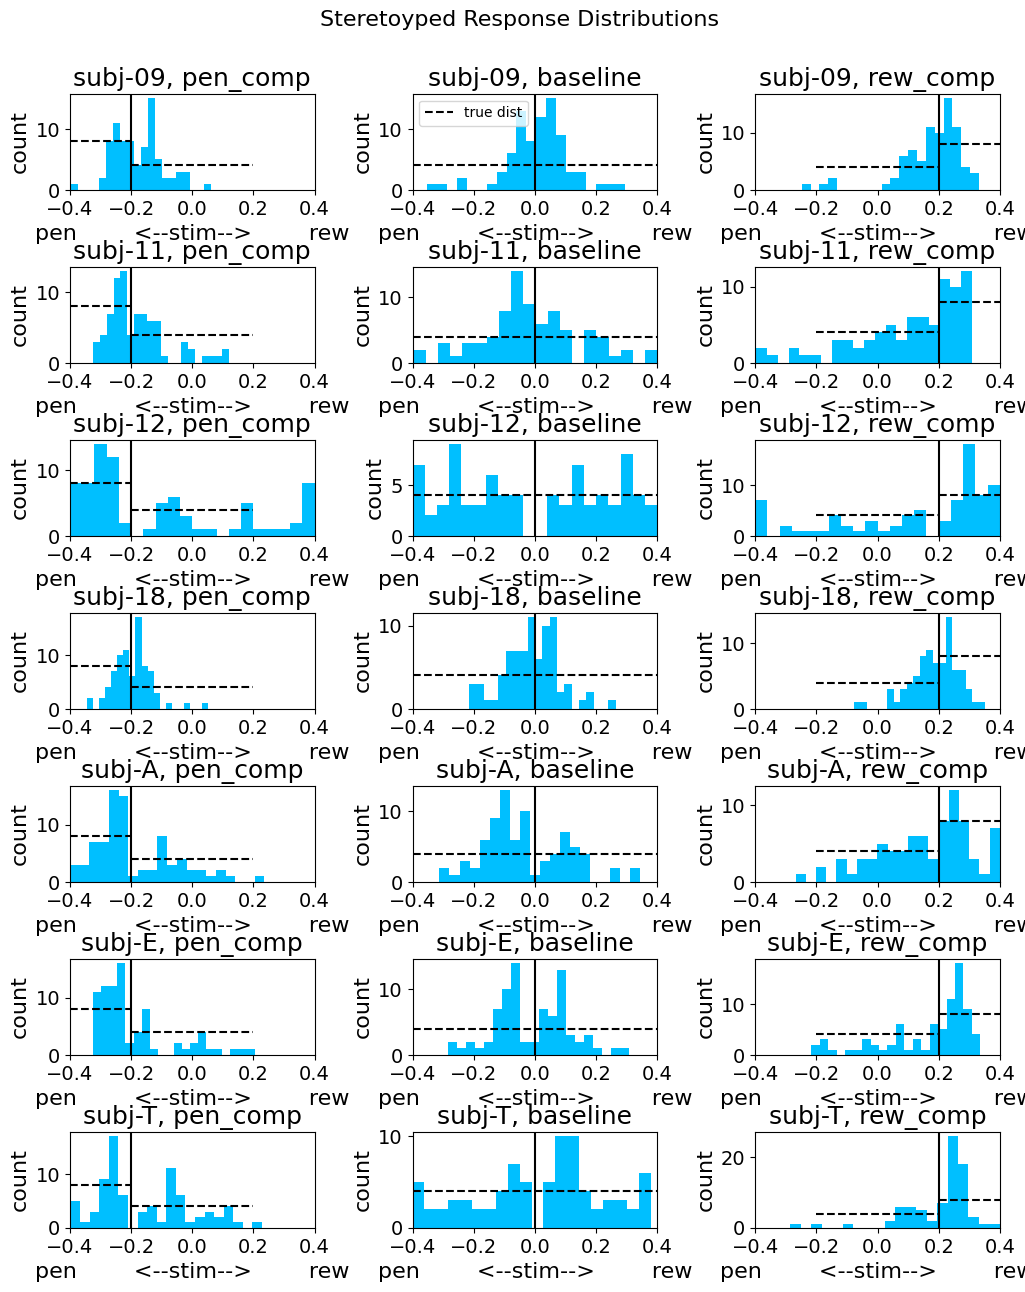

In [48]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# A. individual plots
fig, axs = plt.subplots(len(subjs), 3, figsize=(4*len(conds), 2*len(subjs)))
axs, ax = axs.flatten(), 0

for subj in subjs:
    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

        axs[ax].set(title=f'subj-{subj}, {cond}',
                    xlabel='pen        <--stim-->        rew', ylabel='count', xlim=(-.4, .4))
        axs[ax].hist(subj_cond_df['chosen_pos_aligned'], bins=20, color='deepskyblue')
        axs[ax].axvline(subj_cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='-')
        
        # true dist line depends on cond
        if cond == 'baseline':
            axs[ax].axhline(4, color='black', linestyle='--', label='true dist')
        elif cond == 'pen_comp':
            axs[ax].hlines(8, -.4, -.2, color='black', linestyle='--', label='true dist')
            axs[ax].hlines(4, -.2, .2, color='black', linestyle='--')
        elif cond == 'rew_comp':
            axs[ax].hlines(4, -.2, .2, color='black', linestyle='--', label='true dist')
            axs[ax].hlines(8, .2, .4, color='black', linestyle='--')
        
        ax += 1

axs[1].legend()
plt.suptitle(f'Steretoyped Response Distributions', fontsize=16)
fig.subplots_adjust(wspace=.4, hspace=.8, top=.92)
plt.show()


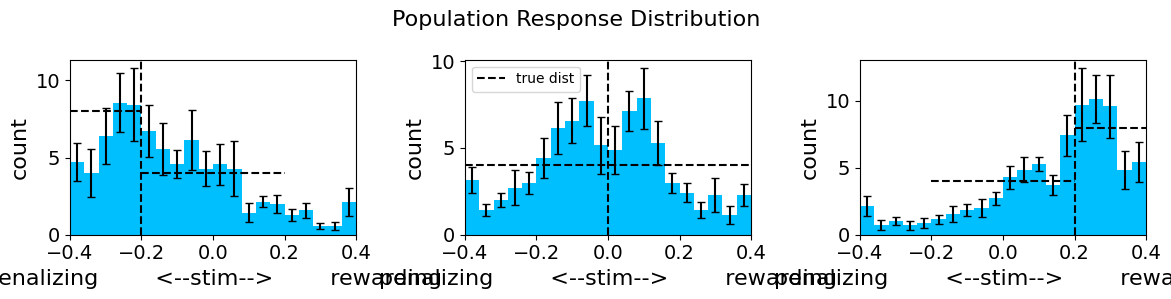

In [49]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# B. population
fig, axs = plt.subplots(1, 3, figsize=(4*len(conds), 3))
axs, ax = axs.flatten(), 0

for cond in conds:
    cond_df = df_analysis[df_analysis['condition'] == cond].copy()

    # compute a histogram of responses per subj
    resp_cts = []
    for subj, subj_df in cond_df.groupby('subj'):
        counts, _ = np.histogram(subj_df['chosen_pos_aligned'], bins=20)
        resp_cts.append(counts)
    resp_cts = np.array(resp_cts)

    mean_resp_cts = resp_cts.mean(axis=0)
    sen_resp_cts = resp_cts.std(axis=0) / np.sqrt(resp_cts.shape[0])

    # plot
    axs[ax].bar(np.linspace(-.38,.38,20), mean_resp_cts, width=.04,
                color='deepskyblue', yerr=sen_resp_cts, capsize=3)

    axs[ax].set(xlabel='penalizing        <--stim-->        rewarding',
                ylabel='count', xlim=(-.4, .4))

    # divider
    axs[ax].axvline(cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='--')

    # true dist lines
    if cond == 'baseline':
        axs[ax].axhline(4, color='black', linestyle='--', label='true dist')
    elif cond == 'pen_comp':
        axs[ax].hlines(8, -.4, -.2, color='black', linestyle='--', label='true dist')
        axs[ax].hlines(4, -.2, .2, color='black', linestyle='--')
    elif cond == 'rew_comp':
        axs[ax].hlines(4, -.2, .2, color='black', linestyle='--', label='true dist')
        axs[ax].hlines(8, .2, .4, color='black', linestyle='--')
 
    ax += 1

axs[1].legend()
plt.suptitle(f'Population Response Distribution', fontsize=16)
plt.tight_layout()
plt.show()


## stim vs resp

In [50]:
# # choose what youre plotting
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# # plot info
# color_map = {False: 'orange', True: 'deepskyblue'}
# label_map = {False: 'incorrect', True: 'correct'}

# n_rows, n_cols = 4, 3
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
# axs, ax = axs.flatten(), 0
# ticks, labels = np.linspace(-.4, .4, 5), np.linspace(0, 1, 5)

# for subj in patients:

#     for cond in conds:
#         subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

#         # SETUP
#         # diagonal for perfect accuracy
#         axs[ax].plot([-.4, .4], [-.4, .4], 'k--', alpha=0.5)

#         # # calculate and plot performance
#         # pearson_r = subj_cond_df['stim_pos_aligned'].corr(subj_cond_df['chosen_pos_aligned'], method='pearson')
#         # accuracy = subj_cond_df['correct'].mean()
#         # axs[ax].text(0.05, 0.95, f'class_acc = {accuracy:.2f}\npearson r = {pearson_r:.2f}', 
#         #             transform=axs[ax].transAxes, verticalalignment='top',
#         #             bbox=dict(boxstyle='round', facecolor='white', alpha=0.4))
            
#         # divider
#         div_pos = subj_cond_df['div_pos_aligned'].iloc[0]
#         axs[ax].axvline(div_pos, color='black', linestyle='-', alpha=0.7)
#         axs[ax].axhline(div_pos, color='black', linestyle='-', alpha=0.7)
        
#         # set
#         # axs[ax].set(title=f'subj-{ax+1}', xlabel='shape position', ylabel='response position',
#         #             xlim=(-.4, .4), ylim=(-.4, .4),
#         #             xticks=ticks, xticklabels=labels, yticks=ticks, yticklabels=labels)

#         axs[ax].set(xlabel='shape position', ylabel='response position',
#                     xlim=(-.4, .4), ylim=(-.4, .4),
#                     xticks=ticks, xticklabels=labels, yticks=ticks, yticklabels=labels)
                
#         # PLOT
#         # points
#         for acc, acc_df in subj_cond_df.groupby('correct'):        
#             axs[ax].scatter(acc_df['stim_pos_aligned'], acc_df['chosen_pos_aligned'],
#                             color=color_map[acc], label=label_map[acc])
                
#         # Calculate mean and SD of chosen position for each stimulus position
#         mean_chosen_per_stim = subj_cond_df.groupby('stim_pos_aligned')['chosen_pos_aligned'].agg(['mean', 'std']).reset_index()
#         mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_pos_aligned')
        
#         # mean
#         axs[ax].plot(mean_chosen_per_stim['stim_pos_aligned'], mean_chosen_per_stim['mean'], color='red')
        
#         # err bars
#         axs[ax].errorbar(mean_chosen_per_stim['stim_pos_aligned'], mean_chosen_per_stim['mean'], 
#                         yerr=mean_chosen_per_stim['std'], color= 'red')

#         ax += 1

# axs[1].legend()
# plt.suptitle('Example Patient Responses across Conditions', fontsize=20)
# fig.subplots_adjust(wspace=.8, hspace=.4, top=.94)
# # plt.tight_layout()
# plt.show()


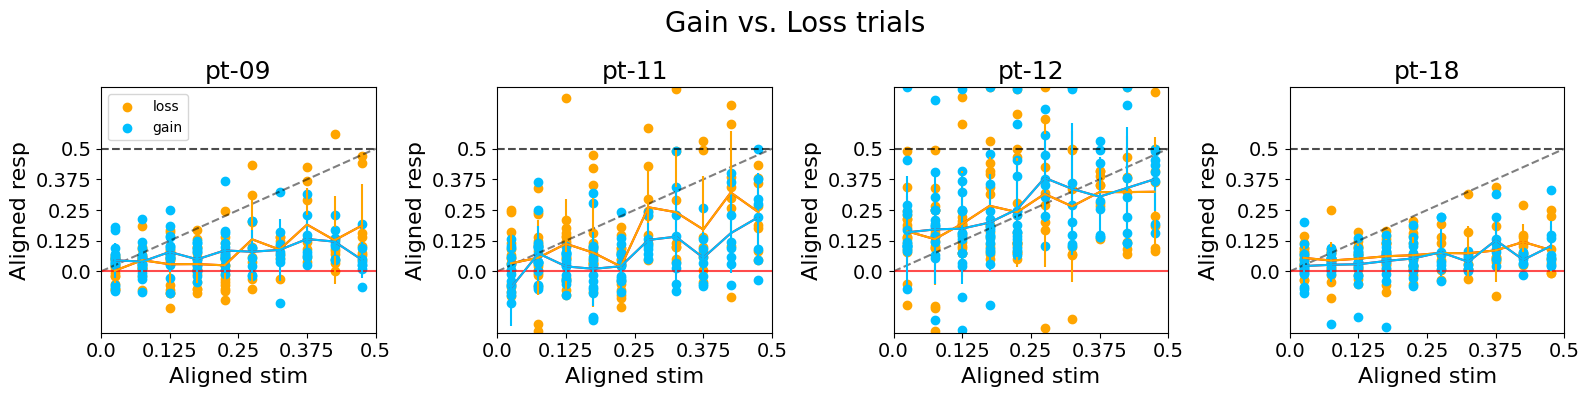

In [134]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# plot info
color_map = {0: 'orange', 1: 'deepskyblue'}
label_map = {0: 'loss', 1: 'gain'}

n_rows, n_cols = 4, 3
n_rows, n_cols = 1, 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axs, ax = axs.flatten(), 0
# ticks, labels = np.linspace(-.4, .4, 5), np.linspace(0, 1, 5)
ticks, labels = np.linspace(0, .4, 5), np.linspace(0, .5, 5)

for subj in patients:

    subj_df = df_analysis[df_analysis['subj'] == subj].copy()

    # for cond in conds:
    #     subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

    axs[ax].plot([0, .4], [0, .4], 'k--', alpha=0.5) # diagonal
    axs[ax].axhline(0, color='red', linestyle='-', alpha=0.7) # correct classification
    axs[ax].axhline(.4, color='black', linestyle='--', alpha=0.7) # only in expanded conds

    axs[ax].set(xlabel='Aligned stim', ylabel='Aligned resp', title=f'pt-{subj}',
                xlim=(0, .4), ylim=(-.2, .6),
                xticks=ticks, yticks=ticks, xticklabels=labels, yticklabels=labels)
            
    # scatter
    for cntxt, cntxt_df in subj_df.groupby('true_class'):
                
        axs[ax].scatter(cntxt_df['stim_aligned_to_cntxt'], cntxt_df['resp_aligned_to_cntxt'],
                        color=color_map[cntxt], label=label_map[cntxt])

        # Calculate mean and SD of chosen position for each stimulus position
        mean_chosen_per_stim = cntxt_df.groupby('stim_aligned_to_cntxt')['resp_aligned_to_cntxt'].agg(['mean', 'std']).reset_index()
        mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_aligned_to_cntxt')
        
        # mean
        axs[ax].plot(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], color='red')
        
        # err bars
        axs[ax].errorbar(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], 
                        yerr=mean_chosen_per_stim['std'], color=color_map[cntxt])

    axs[0].legend()
    ax += 1

plt.suptitle('Gain vs. Loss trials', fontsize=20)
# fig.subplots_adjust(wspace=.8, hspace=.4, top=.94)
plt.tight_layout()
plt.show()


In [146]:
block_df = df_analysis[df_analysis['blockN'] == 1.0].copy()
print(block_df['stim_aligned_to_cntxt'].value_counts()) 

stim_aligned_to_cntxt
0.18    28
0.26    28
0.34    28
0.10    28
0.22    28
0.02    28
0.14    28
0.06    28
0.38    28
0.30    28
Name: count, dtype: int64


1.0 stim_aligned_to_cntxt
0.02    2
Name: count, dtype: int64

2.0 stim_aligned_to_cntxt
0.02    4
Name: count, dtype: int64

3.0 stim_aligned_to_cntxt
0.02    2
Name: count, dtype: int64

4.0 stim_aligned_to_cntxt
0.02    2
Name: count, dtype: int64

5.0 stim_aligned_to_cntxt
0.02    4
Name: count, dtype: int64

6.0 stim_aligned_to_cntxt
0.02    2
Name: count, dtype: int64

1.0 stim_aligned_to_cntxt
0.06    2
Name: count, dtype: int64

2.0 stim_aligned_to_cntxt
0.06    4
Name: count, dtype: int64

3.0 stim_aligned_to_cntxt
0.06    2
Name: count, dtype: int64

4.0 stim_aligned_to_cntxt
0.06    2
Name: count, dtype: int64

5.0 stim_aligned_to_cntxt
0.06    4
Name: count, dtype: int64

6.0 stim_aligned_to_cntxt
0.06    2
Name: count, dtype: int64

1.0 stim_aligned_to_cntxt
0.1    2
Name: count, dtype: int64

2.0 stim_aligned_to_cntxt
0.1    4
Name: count, dtype: int64

3.0 stim_aligned_to_cntxt
0.1    2
Name: count, dtype: int64

4.0 stim_aligned_to_cntxt
0.1    2
Name: count, dtype: int

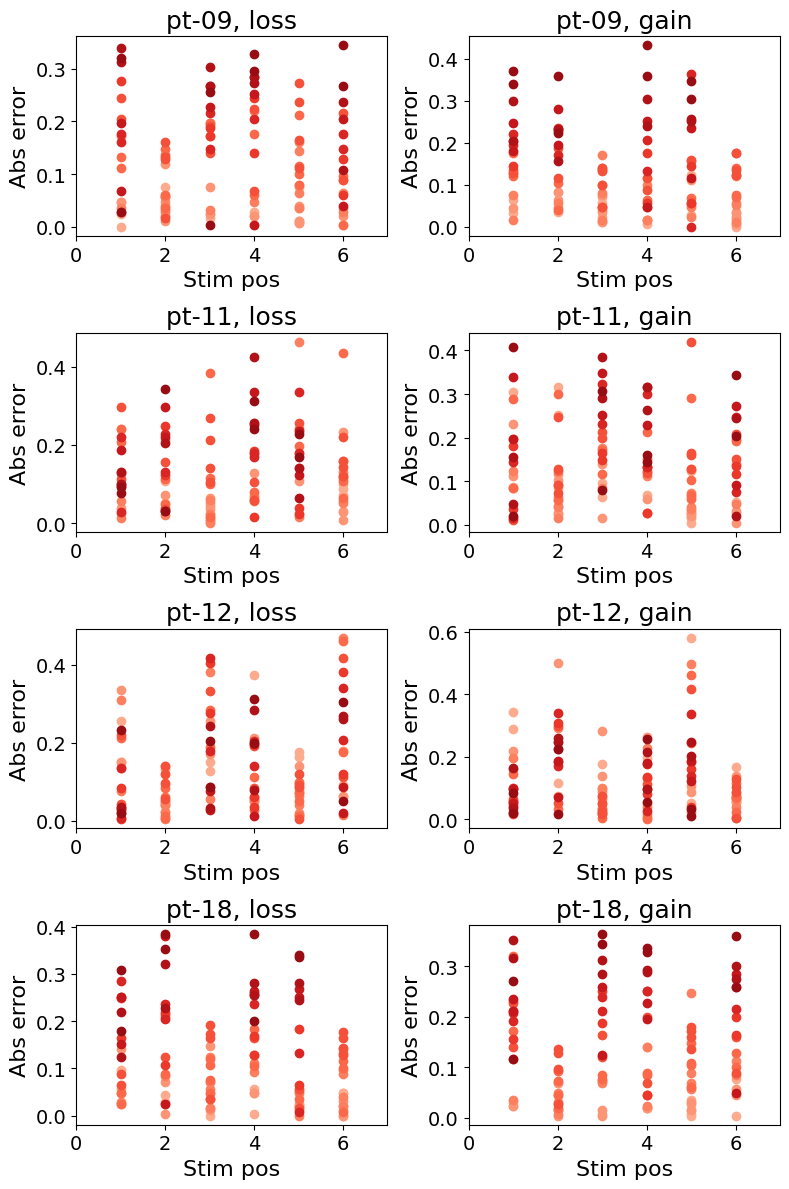

In [151]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# plot info
unique_cntxt_stims = sorted(df_analysis['stim_aligned_to_cntxt'].unique())
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(unique_cntxt_stims)))
color_map = dict(zip(unique_cntxt_stims, colors))
cntxt_rename = {'rew': 'gain', 'pen': 'loss'}

n_rows, n_cols = 4, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axs, ax = axs.flatten(), 0
ticks, labels = np.linspace(0, .4, 5), np.linspace(0, .5, 5)

for subj in patients:

    subj_df = df_analysis[df_analysis['subj'] == subj].copy()

    for cntxt in ['pen', 'rew']: # loss on left, gain on right
        cntxt_df = subj_df[subj_df['valence'] == cntxt].copy()
                    
        # scatter
        for cntxt_stim, cntxt_stim_df in cntxt_df.groupby('stim_aligned_to_cntxt'):

            for block, block_df in cntxt_stim_df.groupby('blockN'):
                print(block, block_df['stim_aligned_to_cntxt'].value_counts(), end='\n\n')

            axs[ax].scatter(cntxt_stim_df['blockN'], cntxt_stim_df['unsigned_err'], color=color_map[cntxt_stim])

            # # Calculate mean and SD of chosen position for each stimulus position
            # mean_chosen_per_stim = cntxt_stim_df.groupby('stim_aligned_to_cntxt')['unsigned_err'].agg(['mean', 'std']).reset_index()
            # mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_aligned_to_cntxt')
            
            # # mean
            # axs[ax].plot(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], color='red')
            
            # # err bars
            # axs[ax].errorbar(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], 
            #                 yerr=mean_chosen_per_stim['std'], color=color_map[cntxt_stim])

        axs[ax].set(title=f'pt-{subj}, {cntxt_rename[cntxt]}',
                    xlabel='Stim pos', ylabel='Abs error',
                    xlim=(0, 7))
        # axs[0].legend()
        ax += 1

# fig.subplots_adjust(wspace=.8, hspace=.4, top=.94)
plt.tight_layout()
plt.show()


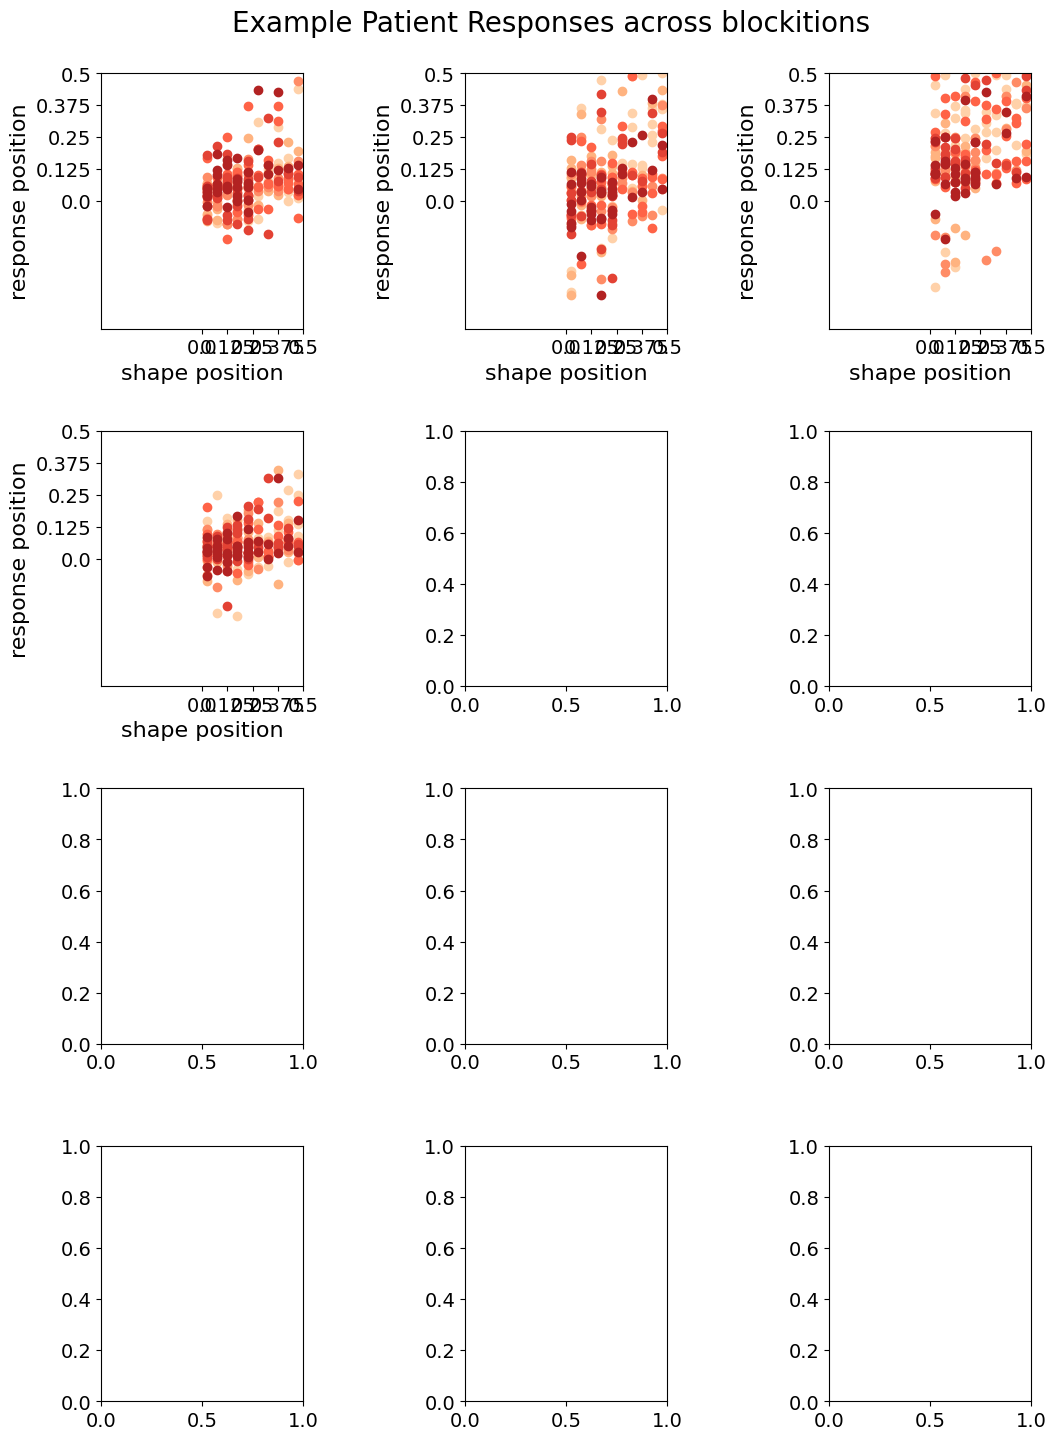

In [77]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# plot info
color_map = {1.0: '#FFD1A9', 2.0: '#FFB380', 3.0: '#FF8C66', 4.0: '#FF6347', 5.0: '#E34234', 6.0: '#B22222'}
label_map = {1.0: 'block 1', 2.0: 'block 2', 3.0: 'block 3', 4.0: 'block 4', 5.0: 'block 5', 6.0: 'block 6'}

n_rows, n_cols = 4, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axs, ax = axs.flatten(), 0
ticks, labels = np.linspace(0, .4, 5), np.linspace(0, .5, 5)

for subj in patients:

    axs[ax].set(xlabel='shape position', ylabel='response position',
                xlim=(-.4, .4), ylim=(-.4, .4),
                xticks=ticks, xticklabels=labels, yticks=ticks, yticklabels=labels)
        
    for block in np.arange(1.0, 6.1, 1.0):
        subj_block_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['blockN'] == block)].copy()

        # axs[ax].plot([0, .4], [0, .4], 'k--', alpha=0.5) # diagonal

        # # divider
        # div_pos = subj_block_df['div_pos_aligned'].iloc[0]
        # axs[ax].axvline(div_pos, color='black', linestyle='-', alpha=0.7)
        # axs[ax].axhline(div_pos, color='black', linestyle='-', alpha=0.7)
                
        # scatter
        for block, block_df in subj_block_df.groupby('blockN'):        
            axs[ax].scatter(block_df['stim_aligned_to_cntxt'], block_df['resp_aligned_to_cntxt'],
                            color=color_map[block], label=label_map[block])
                
        # # Calculate mean and SD of chosen position for each stimulus position
        # mean_chosen_per_stim = subj_block_df.groupby('stim_aligned_to_cntxt')['resp_aligned_to_cntxt'].agg(['mean', 'std']).reset_index()
        # mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_aligned_to_cntxt')
        
        # # mean
        # axs[ax].plot(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], color='red')
        
        # # err bars
        # axs[ax].errorbar(mean_chosen_per_stim['stim_aligned_to_cntxt'], mean_chosen_per_stim['mean'], 
        #                 yerr=mean_chosen_per_stim['std'], color= 'red')

    ax += 1

# axs[1].legend()
plt.suptitle('Example Patient Responses across blockitions', fontsize=20)
fig.subplots_adjust(wspace=.8, hspace=.4, top=.94)
# plt.tight_layout()
plt.show()


In [1]:
print(1)

1


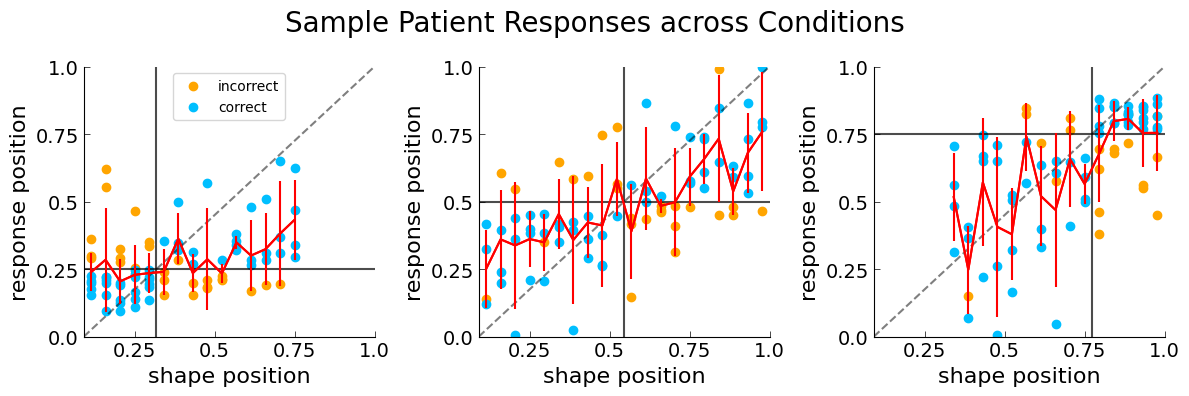

In [53]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, '11')

# plot info
color_map = {False: 'orange', True: 'deepskyblue'}
label_map = {False: 'incorrect', True: 'correct'}

n_rows, n_cols = 1, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axs, ax = axs.flatten(), 0
ticks, labels = np.linspace(-.4, .4, 5), np.linspace(0, 1, 5)

for cond in conds:
    subj_cond_df = df_analysis[df_analysis['condition'] == cond].copy()

    # diagonal for perfect accuracy
    axs[ax].plot([-.4, .4], [-.4, .4], 'k--', alpha=0.5)    
    # divider
    div_pos = subj_cond_df['div_pos_aligned'].iloc[0]
    axs[ax].axvline(div_pos, color='black', linestyle='-', alpha=0.7)
    axs[ax].axhline(div_pos, color='black', linestyle='-', alpha=0.7)

    # set
    axs[ax].set(xlabel='shape position', ylabel='response position',
                xlim=(-.4, .4), ylim=(-.4, .4),
                xticks=np.linspace(-.26, .4, 4), xticklabels=np.linspace(.25, 1, 4), yticks=ticks, yticklabels=labels)
                
    # scatter
    for acc, acc_df in subj_cond_df.groupby('correct'):        
        axs[ax].scatter(acc_df['stim_pos_aligned'], acc_df['chosen_pos_aligned'],
                        color=color_map[acc], label=label_map[acc])
            
    # Calculate mean and SD of chosen position for each stimulus position
    mean_chosen_per_stim = subj_cond_df.groupby('stim_pos_aligned')['chosen_pos_aligned'].agg(['mean', 'std']).reset_index()
    mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_pos_aligned')
    
    # mean
    axs[ax].plot(mean_chosen_per_stim['stim_pos_aligned'], mean_chosen_per_stim['mean'], color='red')
    
    # err bars
    axs[ax].errorbar(mean_chosen_per_stim['stim_pos_aligned'], mean_chosen_per_stim['mean'], 
                    yerr=mean_chosen_per_stim['std'], color= 'red')

    ax += 1

axs[0].legend()
for ax in axs:
    ax.tick_params(direction='in', length=4, width=.5)
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.suptitle('Sample Patient Responses across Conditions', fontsize=20)
# fig.subplots_adjust(wspace=.8, hspace=.4, top=.94)
plt.tight_layout(h_pad=2)
plt.show()

# fig.savefig('../../results/figs/sfn/fig3b_scatter.eps', format='eps', dpi=300)
plt.rcParams['svg.fonttype'] = 'none'  # keeps text editable
fig.savefig('../../results/figs/sfn/fig3b_scatter.svg', format='svg', dpi=300)


## psychometric curves

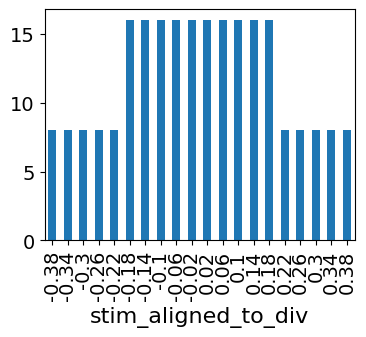

In [54]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, '12')
plt.figure(figsize=(4,3))
df_analysis['stim_aligned_to_div'].value_counts().sort_index().plot(kind='bar')
plt.show()

functions

In [55]:
from scipy.optimize import curve_fit
from scipy.stats import norm
unique_aligned_pos = np.unique(df_analysis['stim_aligned_to_div'])

def logistic(x, threshold, slope):
    return 1 / (1 + np.exp(-(x - threshold) / slope))

def get_subj_psychometric(subj):
    
    subj_df = df_analysis[df_analysis['subj'] == subj]

    subjs_props, subjs_sderrs = [], []

    # calculate proportion right and sd errs per position
    for aligned_pos in unique_aligned_pos:
        
        # all trials with this aligned_pos
        stim_pos_trials = subj_df[subj_df['stim_aligned_to_div'] == aligned_pos]

        # proportion and sderr of pred_class == 1
        prop = stim_pos_trials['pred_class'].mean()
        stderr = np.sqrt(prop * (1 - prop) / len(stim_pos_trials))

        subjs_props.append(prop)
        subjs_sderrs.append(stderr)

    return np.array(subjs_props), np.array(subjs_sderrs)


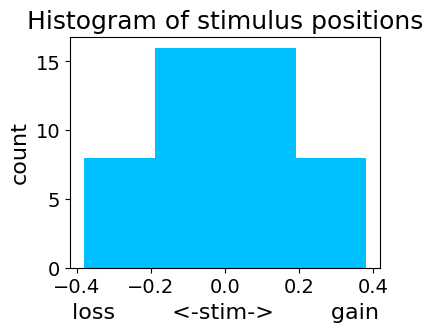

In [56]:
# hist of positions to div
plt.figure(figsize=(4,3))
plt.hist(df_analysis['stim_aligned_to_div'], bins=20, color='deepskyblue')
plt.xlabel('loss        <-stim->        gain')
plt.ylabel('count')
plt.title('Histogram of stimulus positions')
plt.show()

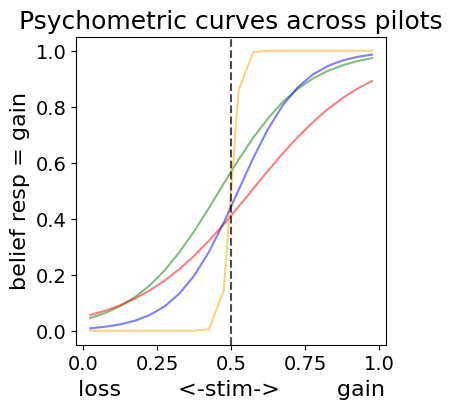

In [57]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

plt.figure(figsize=(4, 4))
ticks, labels = np.linspace(-.4, .4, 5), np.linspace(0, 1, 5)

for pt_idx in range(len(patients)):
    props, sderrs = get_subj_psychometric(patients[pt_idx])

    # fit logistic curve
    param_init = [0, 1]
    [bias, slope], _ = curve_fit(logistic, unique_aligned_pos, props, p0=param_init)
    fitted_curve = logistic(unique_aligned_pos, *[bias, slope])
    
    # plt.errorbar(unique_aligned_pos, props, yerr=1.96*sderrs, fmt='o', ms=3, alpha=0.7)
    plt.plot(unique_aligned_pos, fitted_curve, alpha=0.5, color=pt_colors[pt_idx])
    
    plt.xticks(ticks, labels) # reformat

plt.axvline(0, color='black', linestyle='--', alpha=0.7)
plt.title(f'Psychometric curves across pilots')
plt.xlabel('loss        <-stim->        gain')
plt.ylabel('belief resp = gain')
plt.show()

## accuracy & RT by position

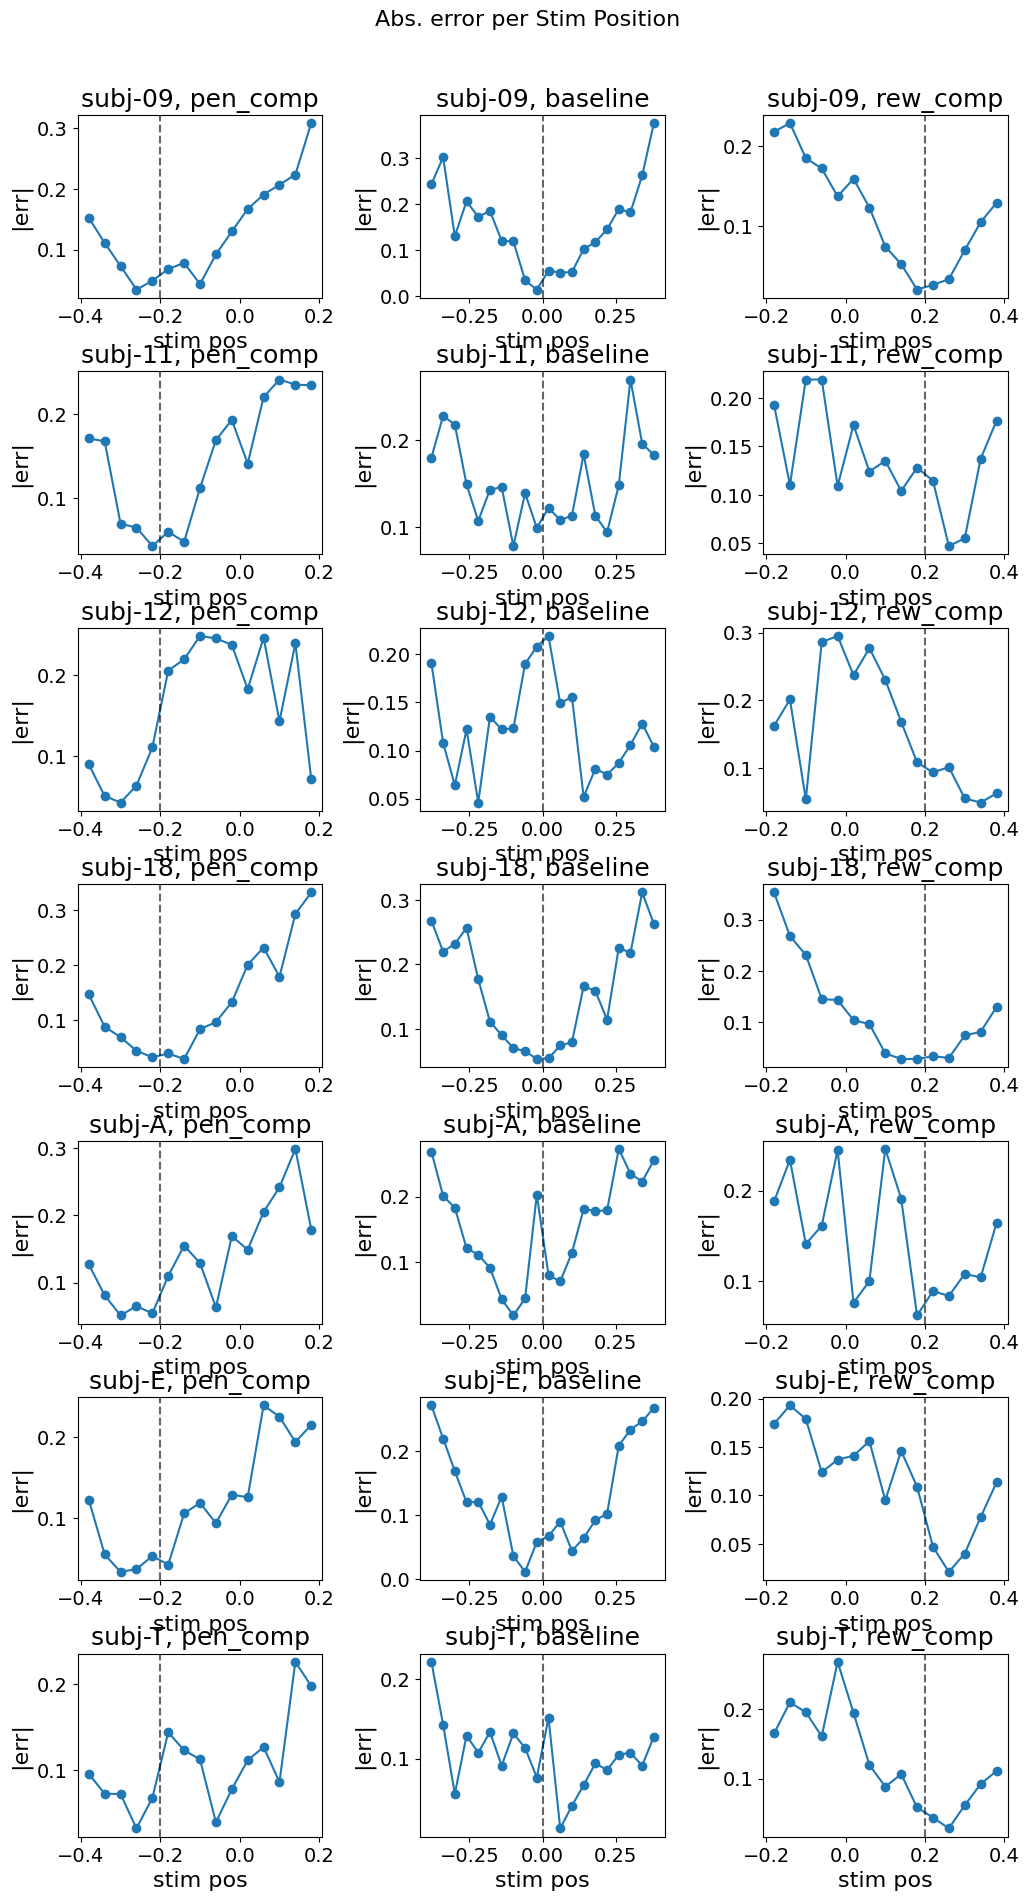

In [58]:
fig, axs = plt.subplots(len(subjs), 3, figsize=(4*len(conds), 3*len(subjs)))
axs, ax = axs.flatten(), 0

for subj in subjs:
    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

        subj_cond_df['|err|'] = np.abs(subj_cond_df['stim_pos_aligned'] - subj_cond_df['chosen_pos_aligned'])
        err_by_stim = subj_cond_df.groupby('stim_pos_aligned')['|err|'].mean()

        axs[ax].plot(err_by_stim.index, err_by_stim.values, marker='o')
        axs[ax].axvline(subj_cond_df['div_pos_aligned'].iloc[0], color='k', linestyle='--', alpha=0.6)
        axs[ax].set(title=f'subj-{subj}, {cond}', xlabel='stim pos', ylabel='|err|')

        ax += 1

plt.suptitle(f'Abs. error per Stim Position', fontsize=16)
fig.subplots_adjust(wspace=.4, hspace=.4, top=.93)
plt.show()


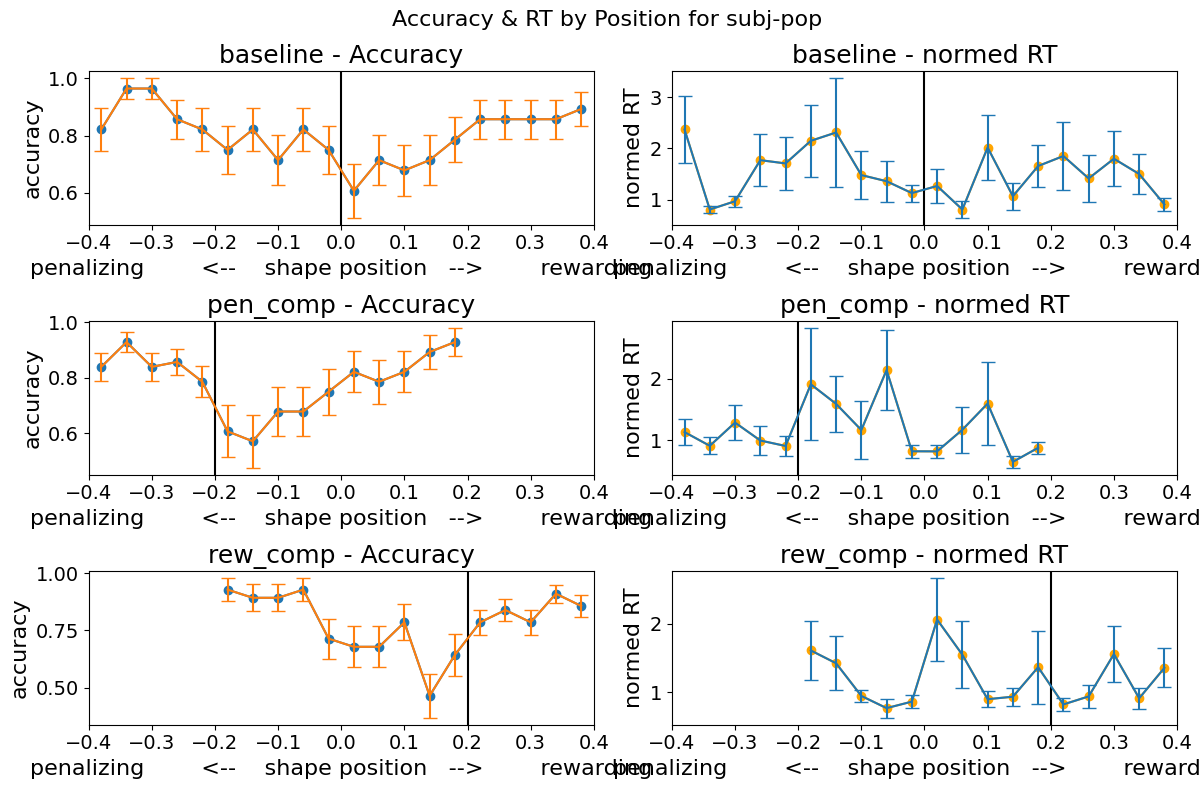

In [59]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

fig, axs = plt.subplots(3, 2, figsize=(12, 8))

for i, (cond, cond_df) in enumerate(df_analysis.groupby('condition')):
    mean_metrics = cond_df.groupby('stim_pos_aligned')[['correct', 'normed_RT']].mean().reset_index()
    sem_metrics  = cond_df.groupby('stim_pos_aligned')[['correct', 'normed_RT']].sem().reset_index()
    
    # Accuracy plot (col 1)
    axs[i, 0].set(xlabel='penalizing        <--    shape position   -->        rewarding', 
                  ylabel='accuracy', xlim=(-.4, .4), title=f'{cond} - Accuracy')
    axs[i, 0].plot(mean_metrics['stim_pos_aligned'], mean_metrics['correct'], marker='o')
    axs[i, 0].errorbar(mean_metrics['stim_pos_aligned'], mean_metrics['correct'], 
                       yerr=sem_metrics['correct'].values, capsize=5)
    axs[i, 0].axvline(cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='-')
    
    # RT plot (col 2)
    axs[i, 1].set(xlabel='penalizing        <--    shape position   -->        rewarding', 
                  ylabel='normed RT', xlim=(-.4, .4), title=f'{cond} - normed RT')
    axs[i, 1].plot(mean_metrics['stim_pos_aligned'], mean_metrics['normed_RT'], marker='o', color='orange')
    axs[i, 1].errorbar(mean_metrics['stim_pos_aligned'], mean_metrics['normed_RT'], 
                       yerr=sem_metrics['normed_RT'].values, capsize=5)
    axs[i, 1].axvline(cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='-')

plt.suptitle(f'Accuracy & RT by Position for subj-{subj_or_pop}', fontsize=16)
plt.tight_layout()
plt.show()


# 6. analyses by valence & compression

condition
baseline    560
pen_comp    560
rew_comp    560
Name: count, dtype: int64
correct
1.0    1347
0.0     333
Name: count, dtype: int64
outcome
 1.0    683
 3.0    664
-1.0    176
-3.0    157
Name: count, dtype: int64


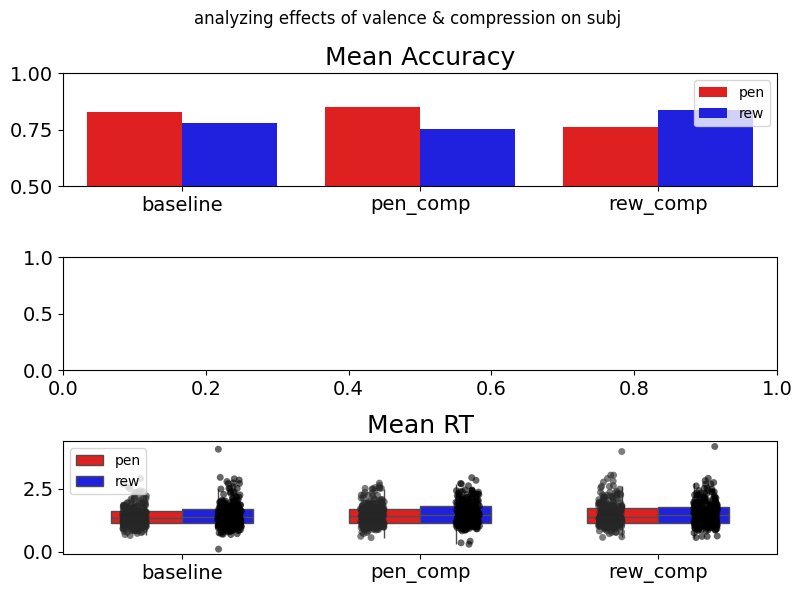

In [60]:
# df_plot = df_hard.copy()
df_plot = df_analysis.copy()

df_plot['correct'] = df_plot['correct'].apply(lambda x: 0 if x == -1 else x)
print(df_plot['condition'].value_counts())
print(df_plot['correct'].value_counts())
print(df_plot['outcome'].value_counts())

fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes = axes.flatten()
fig.suptitle('analyzing effects of valence & compression on subj')
palette, hue_order = {'rew': 'blue', 'pen': 'red'}, ['pen', 'rew']

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='condition', y='correct', hue='valence', hue_order=hue_order, palette = palette, ax=ax, errorbar=None)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(.5, 1)
ax.set_title('Mean Accuracy')
ax.legend()

# 2.
# ax = axes[1]
# sns.boxplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence', hue_order = hue_order,
#             palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)
# sns.stripplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence', hue_order = hue_order, 
#               dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_title('Mean Absolute Error')
# ax.legend()

# 3.
ax = axes[2]
sns.boxplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence', hue_order = hue_order,
            palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)
sns.stripplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence', 
              dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')
ax.legend()


plt.tight_layout()
plt.show()

## analyses by valence space

percept_space
curvy         420
very_curvy    420
very_flat     420
flat          420
Name: count, dtype: int64


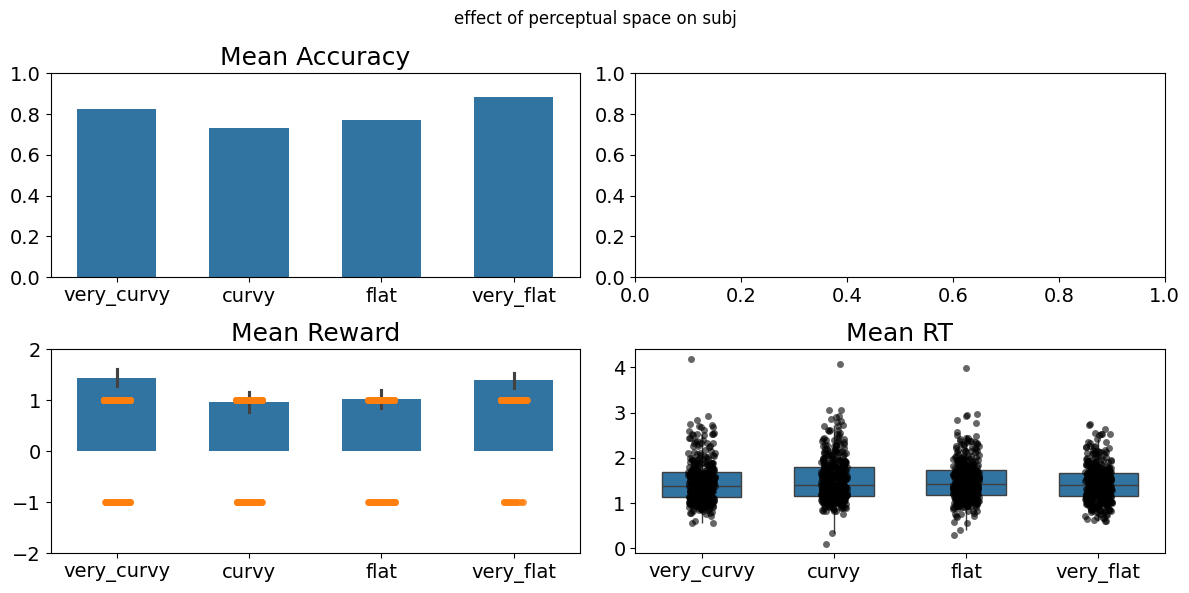

In [61]:
df_plot = df_analysis.copy()

conditions = [
    (-0.4 < df_plot['stim_pos']) & (df_plot['stim_pos'] < -0.2),
    (-0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0),
    (0 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.2),
    (0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.4)
]
percept_labels = ['very_curvy', 'curvy', 'flat', 'very_flat']
df_plot['percept_space'] = np.select(conditions, percept_labels, default= 'undefined')

# arnav's percept space will be flipped
print(df_plot['percept_space'].value_counts())

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
fig.suptitle('effect of perceptual space on subj')

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='percept_space', y='correct', width=0.6, ax=ax, errorbar=None, order=percept_labels)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.set_title('Mean Accuracy')

# 2. MAE
# ax = axes[1]
# sns.boxplot(data=df_plot, x='percept_space', y='MAE_normed', showcaps=False, fliersize=0, width=0.6, ax=ax, order=percept_labels)
# sns.stripplot(data=df_plot, x='percept_space', y='MAE_normed', color='black', dodge=True, alpha=0.6, jitter=True, legend=False, order=percept_labels, ax=ax)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_ylim(0, .6)
# ax.axhline(y=.4, color='black', linestyle='--', label = 'max error on correct side')
# ax.set_title('Mean Absolute Error (questionable norming)')

# 3. reward
ax = axes[2]
sns.barplot(data=df_plot, x='percept_space', y='outcome', width=0.6, hue_order=hue_order, order=percept_labels, ax=ax)
sns.stripplot(data=df_plot, x='percept_space', y='outcome', dodge=True, alpha=0.8, jitter=True, order=percept_labels, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(-2, 2)
ax.set_title('Mean Reward')

# 4. RT
ax = axes[3]
sns.boxplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', showcaps=False, fliersize=0, width=0.6, ax=ax, order=percept_labels)
sns.stripplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', color='black', dodge=True, alpha=0.6, jitter=True, order=percept_labels, legend=True, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')

plt.tight_layout()
plt.show()



## plot class - class_hat

In [62]:
# Step 1: Get mean accuracy per subject (across all conditions and valences)
subj_acc = df_subjs.groupby('subj')['correct'].mean().reset_index()

# Step 2: Compute SD across those subject-level accuracies
overall_sd = subj_acc['correct'].std()

print(f"SD across subjects: {overall_sd}")


SD across subjects: 0.08196293845649558


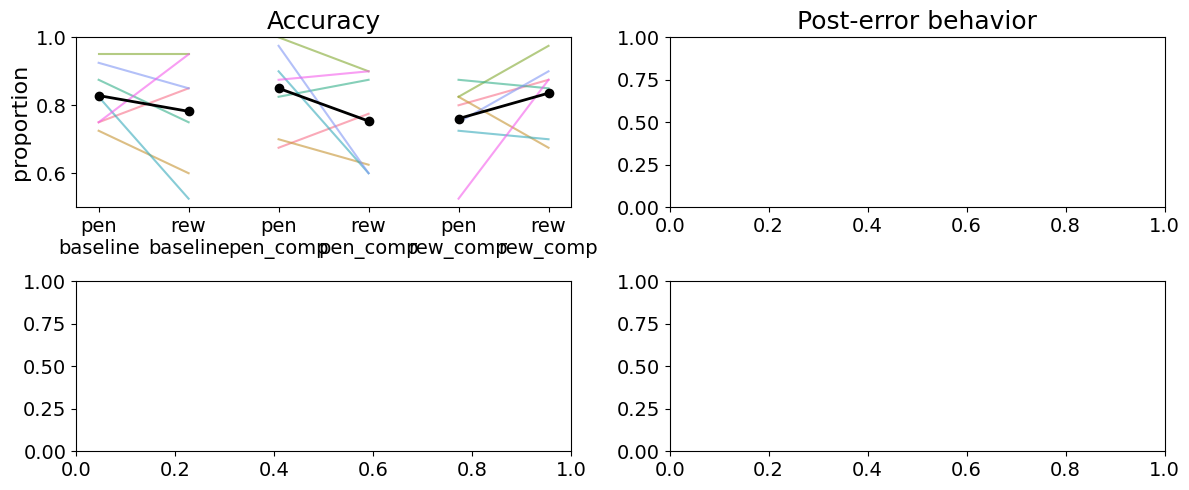

In [63]:
# compute subject-level accuracy by valence & condition
subj_acc_df = df_subjs.groupby(['subj','condition','valence'])['correct'].mean().reset_index()

subj_acc_df['x_label'] = subj_acc_df['valence'].astype(str) + '\n' + subj_acc_df['condition'].astype(str)

# assign colors to subjects
subj_palette = dict(zip(subj_acc_df['subj'].unique(),
                        sns.color_palette('husl', n_colors=subj_acc_df['subj'].nunique())))

# compute population mean by condition & valence
pop_acc_df = subj_acc_df.groupby(['condition','valence'])['correct'].mean().reset_index()
pop_acc_df['x_label'] = pop_acc_df['valence'].astype(str) + '\n' + pop_acc_df['condition'].astype(str)

fig, axs = plt.subplots(2, 2, figsize=(12, 5))
axs, ax = axs.flatten(), 0

axs[ax].set_title('Accuracy')
# plot subjs
for subj, sub_df in subj_acc_df.groupby('subj'):
    for cond, cond_df in sub_df.groupby('condition'):
        axs[ax].plot(cond_df['x_label'], cond_df['correct'].values,
                     color=subj_palette[subj], alpha=0.6)

# plot population
for cond, cond_df in pop_acc_df.groupby('condition'):
    axs[ax].plot(cond_df['x_label'], cond_df['correct'].values,
                 color='black', marker='o', linewidth=2)

axs[ax].set(ylabel='proportion', ylim=(.5, 1))
ax += 1

# post error behavior
axs[ax].set_title('Post-error behavior')
df_post_err = df_subjs[df_subjs['correct'].shift(-1) == False]

plt.tight_layout()
plt.show()


## rewards

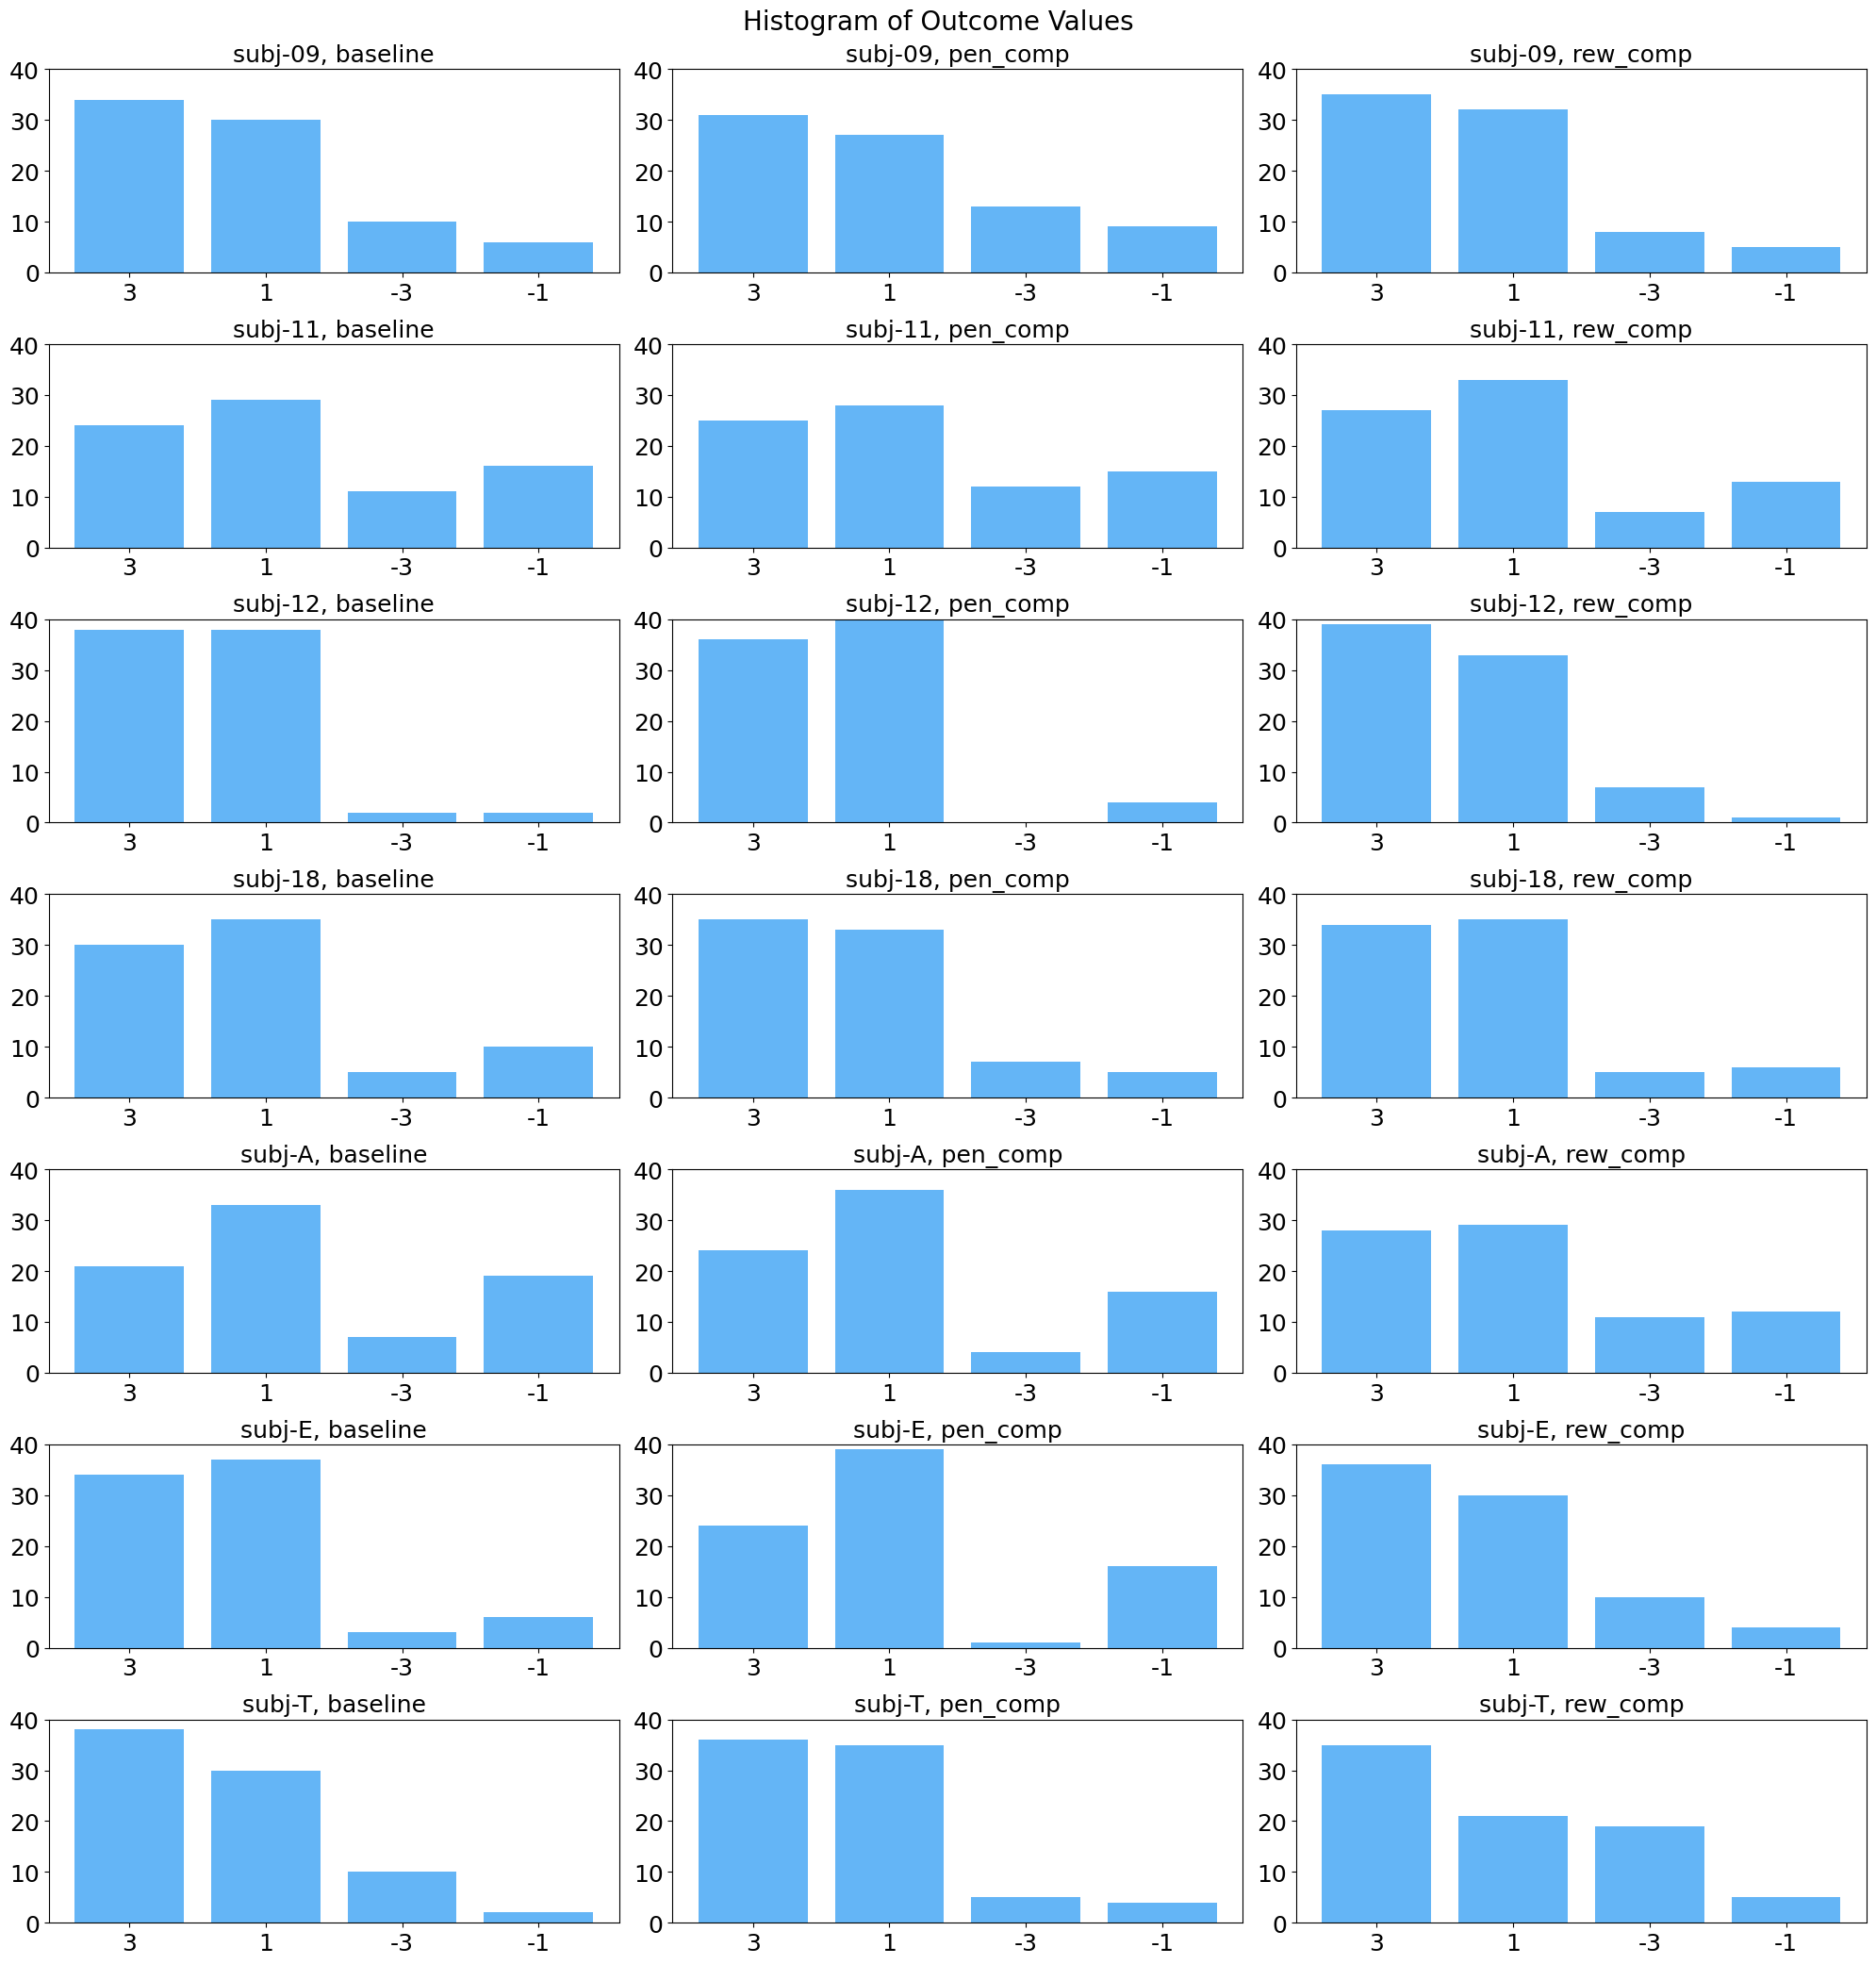

In [64]:
# filter + safe copy
df_attempted = df_analysis.loc[df_analysis['outcome'].isin([1, -1, 3, -3])].copy()

val_order = [3, 1, -3, -1]                  # desired order
label   = [str(v) for v in val_order]         # or ["+3","+1","−3","−1"]

fig, axs = plt.subplots(len(subjs), 3, figsize=(20, 3*len(subjs)))
axs, ax = axs.flatten(), 0

for subj in subjs:
    for cond in df_attempted['condition'].unique():
        
        subj_cond_df = df_attempted[(df_attempted['subj'] == subj) &
                          (df_attempted['condition'] == cond)]

        # counts in desired order (fill zeros)
        counts = subj_cond_df['outcome'].value_counts().reindex(val_order, fill_value=0)

        # plot using fixed positions
        axs[ax].bar(range(4), counts.values, color='#64B5F6')

        axs[ax].set_ylim(0, 40)
        axs[ax].set_xticks(range(4))
        axs[ax].set_xticklabels(label, fontsize=18)
        axs[ax].tick_params(axis='y', labelsize=18)
        axs[ax].set_title(f'subj-{subj}, {cond}', fontsize=18)
        ax += 1

plt.suptitle('Histogram of Outcome Values', fontsize=20, y=.99)
plt.tight_layout()
plt.show()
